# Mask RCNN 실행 환경설정

## 깃허브에서 바로 파일 가져오는 방식 기준

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 경로 설정
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
# Mask-RCNN 설치
!git clone https://github.com/matterport/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [ ]:
# 경로 설정
%cd /content/drive/MyDrive/Mask_RCNN

/content/drive/MyDrive/Mask_RCNN


In [ ]:
# coco 설치 안해도 상관 없음
!git clone https://github.com/waleedka/coco

fatal: destination path 'coco' already exists and is not an empty directory.


In [ ]:
# github에 있는 기본 mask-rcnn 필요 라이브러리 한번에 설치
pip install -r requirements.txt

In [ ]:
# install tf,keras version
# mask rcnn을 가동하기 위한 tensorflow와 keras 버전 다운그래이드
!pip install tensorflow==1.13.1
!pip install tensorflow-gpu==1.13.1
!pip install keras==2.0.8
!pip install h5py==2.10.0

In [ ]:
# requirement.txt 와 마찬가지로 기본 mask rcnn 요구 라이브러리 설치
!python setup.py install

In [ ]:
# 경로 재지정
%cd /content/drive/MyDrive/Mask_RCNN/samples

/content/drive/MyDrive/Mask_RCNN/samples


## 구글 드라이브에 저장해서 이용하는 방식 기준

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd /content/gdrive/My Drive/mrcnn_apple

In [ ]:
!pip install import_ipynb
import import_ipynb

# 필요한 버전으로 다운그레이드
!pip install tensorflow==1.13.1
!pip install keras==2.1.5
!pip install h5py==2.10.0 --force-reinstall

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 필수 라이브러리 import
import os
import sys
import itertools
import math
import logging
import json
import re
import random

from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

import skimage.io

In [ ]:
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/gdrive/MyDrive/mrcnn_apple")

In [ ]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [ ]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

Using TensorFlow backend.


In [ ]:
import apple as am

# Mask RCNN 실행

## Configuration

In [ ]:
class InferenceConfig(am.AppleConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
DEVICE = "/cpu:0"
TEST_MODE = "inference"

## Load Model, Weights

In [ ]:
import tensorflow as tf

In [ ]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [ ]:
# 가중치 파일 경로
weights_path = "/content/gdrive/MyDrive/logs/apple20220822T0123/mask_rcnn_apple_0020.h5"

# Load weights
model.load_weights(weights_path, by_name=True)

Re-starting from epoch 20


### 데이터 불러오기

In [ ]:
SAMPLE_IMG_PATH = '/content/gdrive/MyDrive/val'

image_list = os.listdir(SAMPLE_IMG_PATH)
image_list_py = [file for file in image_list if file.endswith('.jpg')]

In [ ]:
class_names = ['BG', 'apple']

In [ ]:
print("Image Count: {}".format(len(image_list_py)))

Image Count: 480


### 데이터 리스트 분할하기

In [ ]:
# 데이터 리스트 분할하는 함수 정의
def list_chunk(lst, n):
    return [lst[i:i+n] for i in range(0, len(lst), n)]

* 리스트를 나눌때 사용할 함수를 정의하고 사용한 이유 = 한번에 많은양의 이미지의 좌표를 얻기위해 불러온 모든 이미지들을 한번에 사용하면 코랩에서 한번에 사용가능한 무료 램 사용량 한계에 도달하여 중간중간 계속 끊기는 현상이 발생하여 불러온 이미지들을 한번에 모델 학습이 가능한 양으로 나누어서 좌표를 획득하고 이를 csv파일 형태로 저장한 다음 추후 이를 불러와서 합치는 과정으로 진행

In [ ]:
# 데이터 리스트 분할하기
image_list_py_80 = list_chunk(image_list_py, 80)

In [ ]:
# 마지막 리스트 개수 확인
len(image_list_py_80[5])

80

## 모델 적용 예시

In [ ]:
image_name = random.choice(image_list_py)
image_name

'20211010_RGB_11.3_F03_SG_03_092_12_0_H.jpg'

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Image Name : 20211010_RGB_11.3_F03_SG_03_092_12_0_H.jpg
Processing 1 images
image                    shape: (2560, 1707, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2560.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


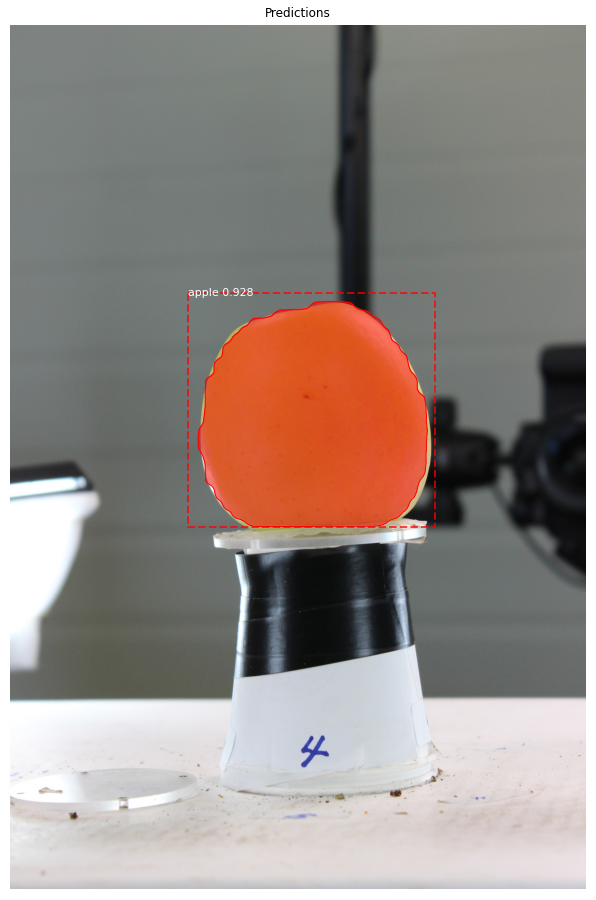

In [ ]:
image = skimage.io.imread('../val/' + image_name)
print("Image Name : {}".format(image_name))

# Run object detection
results = model.detect([image], verbose=1)
r = results[0]

# Display results
ax = get_ax(1)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'], ax=ax, title="Predictions")

## Mask Coordination 추출

In [ ]:
temp_ = {}
num = 0

for i in image_list_py_80[5]:
    temp = skimage.io.imread('../val/' + i)
    print("Image Name : {}".format(i))

    # Run object detection
    results = model.detect([temp], verbose=1)
    r = results[0]

    mask = r['masks']
    mask = mask.astype(int)

    for i in range(mask.shape[2]):
        temp, window, scale, padding, _ = utils.resize_image(temp, 
                                                            min_dim=config.IMAGE_MIN_DIM, 
                                                            max_dim=config.IMAGE_MAX_DIM, 
                                                            mode=config.IMAGE_RESIZE_MODE)
        mask, window, scale, padding, _ = utils.resize_image(mask, 
                                                            min_dim=config.IMAGE_MIN_DIM, 
                                                            max_dim=config.IMAGE_MAX_DIM, 
                                                            mode=config.IMAGE_RESIZE_MODE)
        for j in range(temp.shape[2]):
            temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
        
        # 좌표 데이터 0이 아닌 부분만 저장
        temp_[num] = (temp>0).nonzero() 

        print(f'\n{num}번째 사과 이미지 mask 좌표 추출 완료\n\n')        
        num += 1

Image Name : 20211010_RGB_12.7_F01_SG_04_006_15_45_H.jpg
Processing 1 images
image                    shape: (2560, 1707, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2560.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

0번째 사과 이미지 mask 좌표 추출 완료


Image Name : 20211010_RGB_12.8_F01_SG_03_023_04_0_H.jpg
Processing 1 images
image                    shape: (2560, 1707, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2560.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

1번째 사과 이미지 mask 좌표 추출 완료


Image Name : 20211010_RGB_1

## Mask Coordination 전처리

In [ ]:
# 첫번째 mask coordination 전처리
temp_[0] = np.concatenate((temp_[0][0],temp_[0][1],temp_[0][2]), axis = 0)
temp_[0] = np.array2string(temp_[0])
temp_[0] = {'segmentation':temp_[0]}

* 모델을 통해 획득한 temp의 구성형태의 경우 3개의 array가 들어가있는 형태로 구해지기 때문에 위의 과정을 수행
  * 3개의 array를 한개로 통합
  * 넘파이 배열의 문자형 표현을 반환
  * 사전형식으로 저장

In [ ]:
# mask coordination 담는 데이터프레임 생성
df = pd.DataFrame(temp_[0], index = [0])

In [ ]:
# 나머지 mask coordination 데이터프레임에 추가
for i in range(1,len(image_list_py_80[5])):
    temp_[i] = np.concatenate((temp_[i][0],temp_[i][1],temp_[i][2]), axis = 0)
    temp_[i] = np.array2string(temp_[i])
    temp_[i] = {'segmentation':temp_[i]}
    df.loc[i] = temp_[i]

* 첫번재 이미지의 좌표에 대한 전처리와 동일한 과정 수행후 만들어진 데이터프레임에 행으로 추가

In [ ]:
# 이미지 이름 열 추가
df['img_file_name'] = image_list_py_80[5]

In [ ]:
df

,segmentation,img_file_name
0,[359 359 359 ... 0 1 2],20211010_RGB_12.7_F01_SG_04_006_15_45_H.jpg
1,[637 637 637 ... 0 1 2],20211010_RGB_12.8_F01_SG_03_023_04_0_H.jpg
2,[402 402 402 ... 0 1 2],20211010_RGB_12.9_F01_SG_02_021_09_90_H.jpg
3,[419 419 419 ... 0 1 2],20211010_RGB_13.0_F01_SG_02_060_06_45_H.jpg
4,[376 376 376 ... 0 1 2],20211010_RGB_13.2_F02_SG_01_020_03_0_H.jpg
...,...,...
75,[],20211024_RGB_13.9_F02_HJ_04_085_16_45_H.jpg
76,[699 699 699 ... 0 1 2],20211024_RGB_12.2_F02_HJ_02_081_01_0_H.jpg
77,[],20211024_RGB_13.1_F02_HJ_02_051_07_45_H.jpg
78,[399 399 399 ... 0 1 2],20211024_RGB_10.4_F02_HJ_10_026_03_0_H.jpg


In [ ]:
# 데이터프레임 저장 위치
%cd /content/drive/MyDrive/이미지 좌표2

/content/drive/MyDrive/이미지 좌표2


In [ ]:
# csv형태로 저장
df.to_csv("val5.csv")